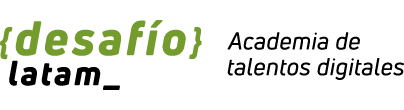
#<center><strong><font color = 'green'>Solución Desafío - Prediciendo las ventas de la tienda</font></strong></center>

<Axes: xlabel='Order Date'>

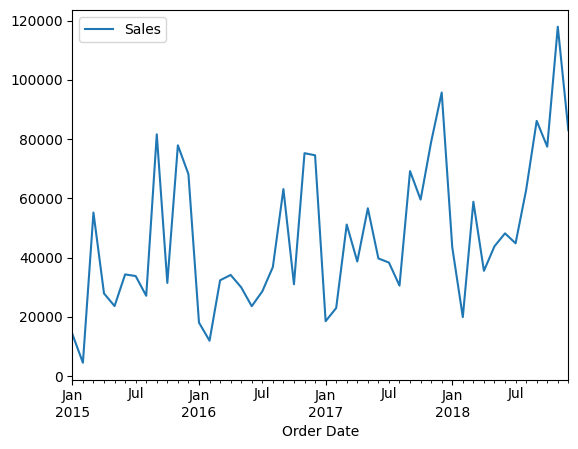

In [5]:
#cargamos las bibliotecas y la data
!pip install pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
data = pd.read_excel('Sales_Data.xlsx')
data['Order Date'] = pd.to_datetime(data['Order Date'])
data.set_index('Order Date', inplace=True)

data.plot()

## Componentes de la Serie de Tiempo

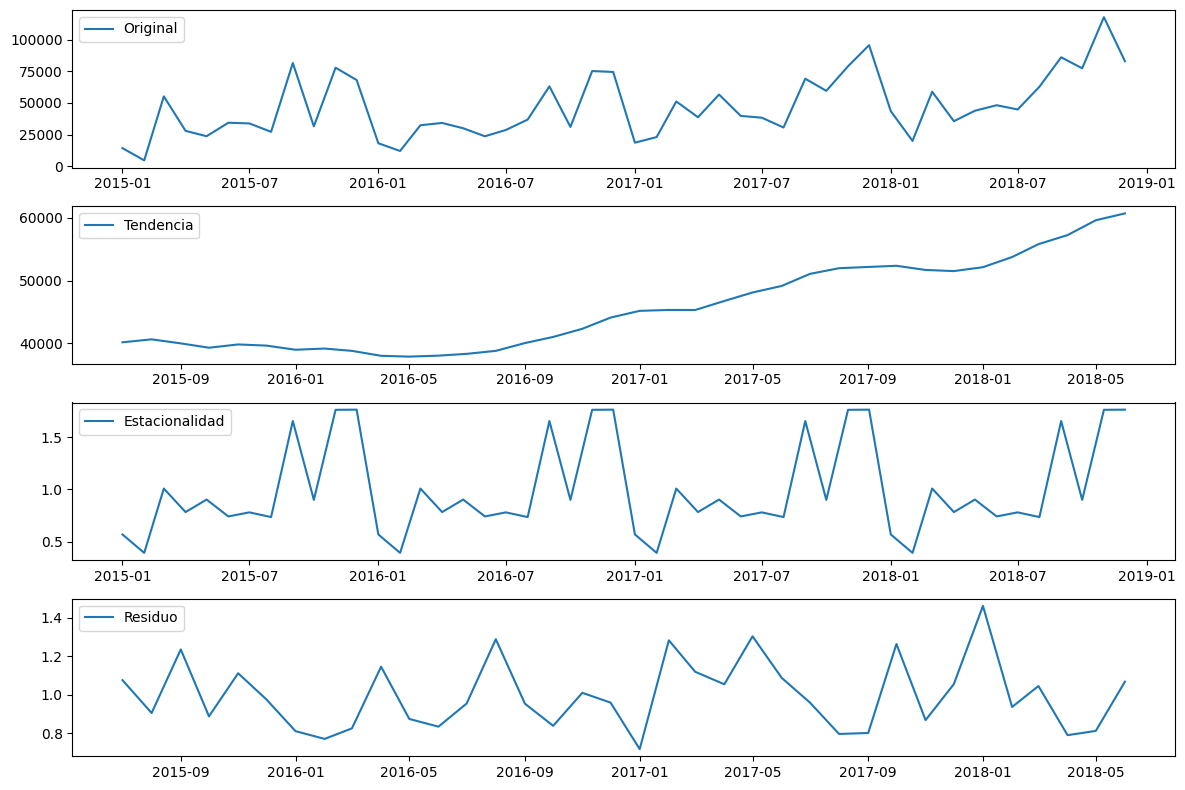

In [6]:
# Descomposición de la serie de tiempo en componentes
result = seasonal_decompose(data, model='multiplicative')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Mostrar los componentes descompuestos
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Estacionaria - Dickey-Fuller

In [7]:
d = 0
p_value = adfuller(data['Sales'])[1]
diff_data = data['Sales']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1


print(f'P Value: {p_value}\t Number of differencing needed: {d}')

P Value: 0.00027791039276670623	 Number of differencing needed: 0


## PACF y ACF

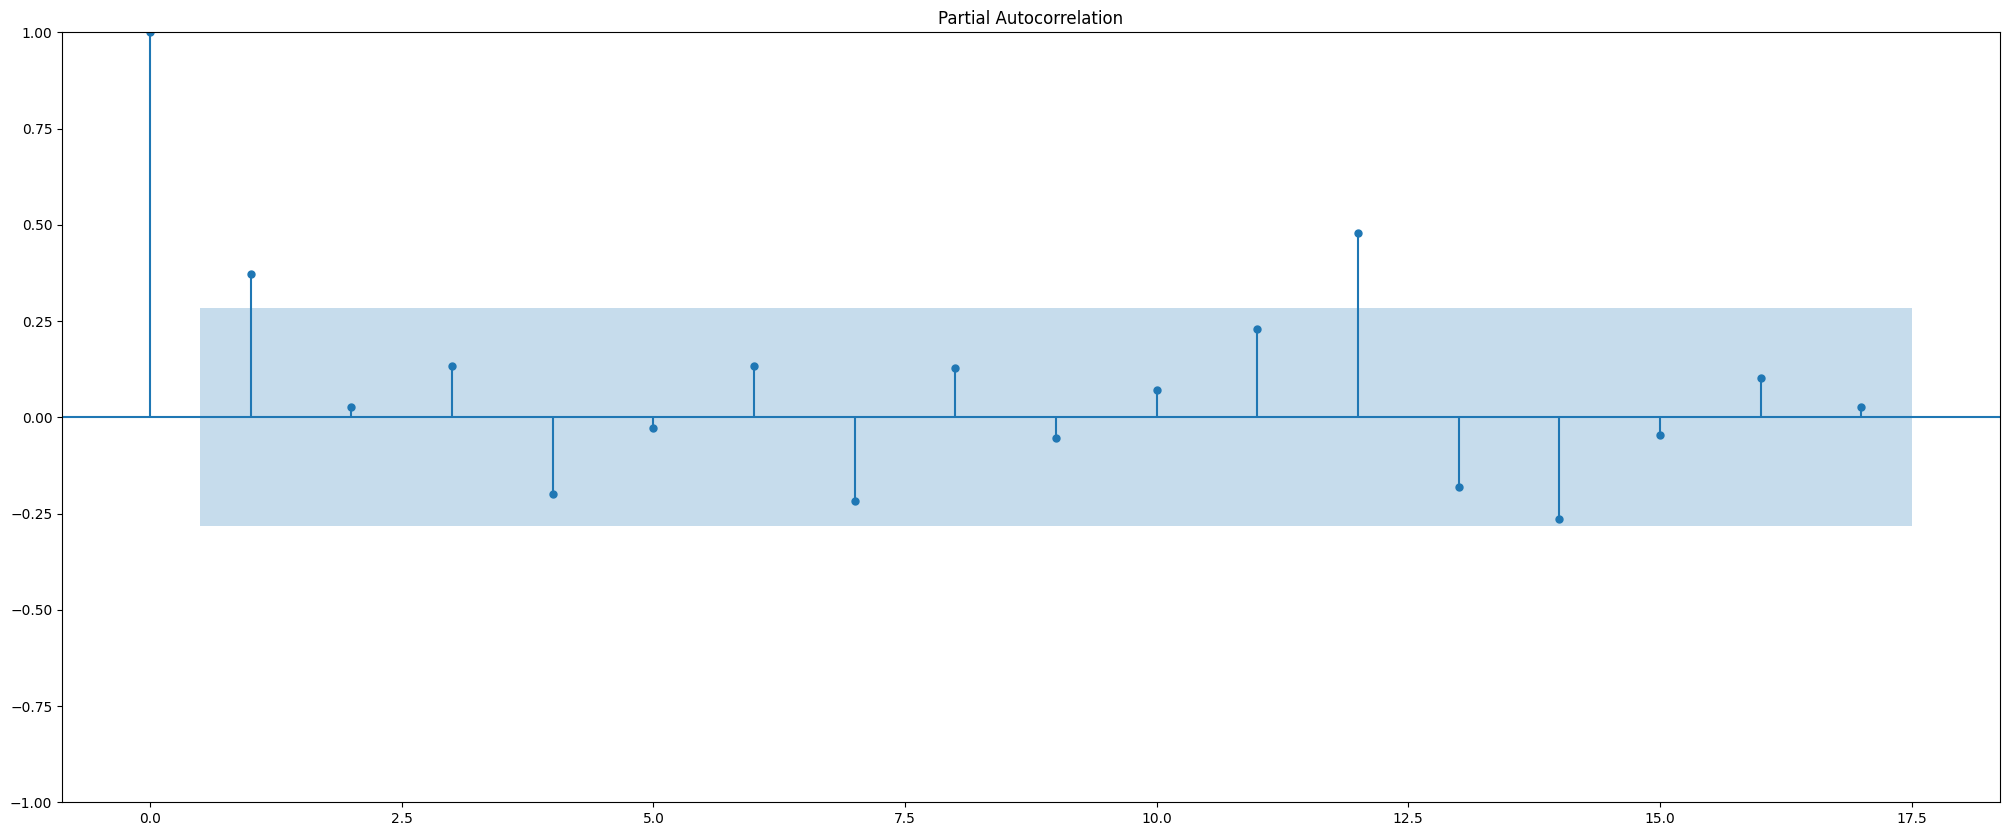

In [8]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(diff_data.dropna(), ax=ax)
plt.show()

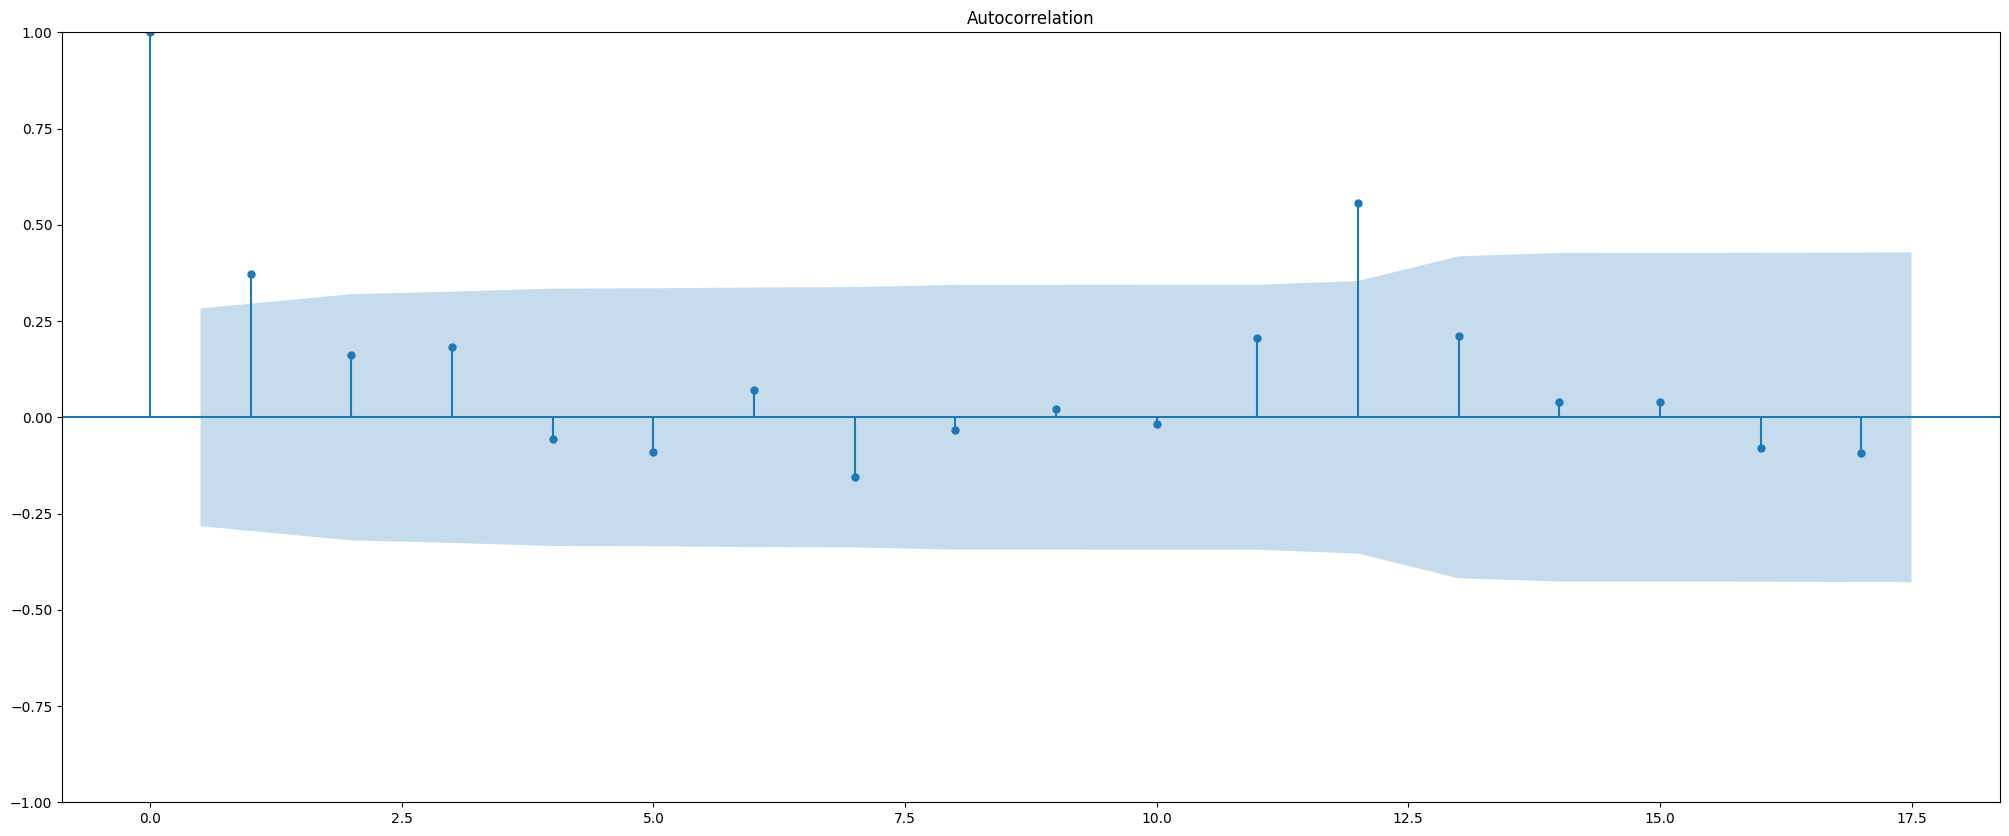

In [9]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(diff_data.dropna(), ax=ax)
plt.show()

## Split Data

In [10]:
# Separar los datos en entrenamiento y prueba
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

## Modelos

In [11]:
# ARIMA
model_arima = ARIMA(train_data['Sales'], order=(12, 0, 12))
model_arima_fit = model_arima.fit()

# auto_arima
model_auto_arima = auto_arima(train_data['Sales'], seasonal=True, m=12)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Predicciones y Testeo

In [12]:
# Realizar predicciones
forecast_arima = model_arima_fit.forecast(steps=len(test_data))
forecast_auto_arima = model_auto_arima.predict(n_periods=len(test_data))

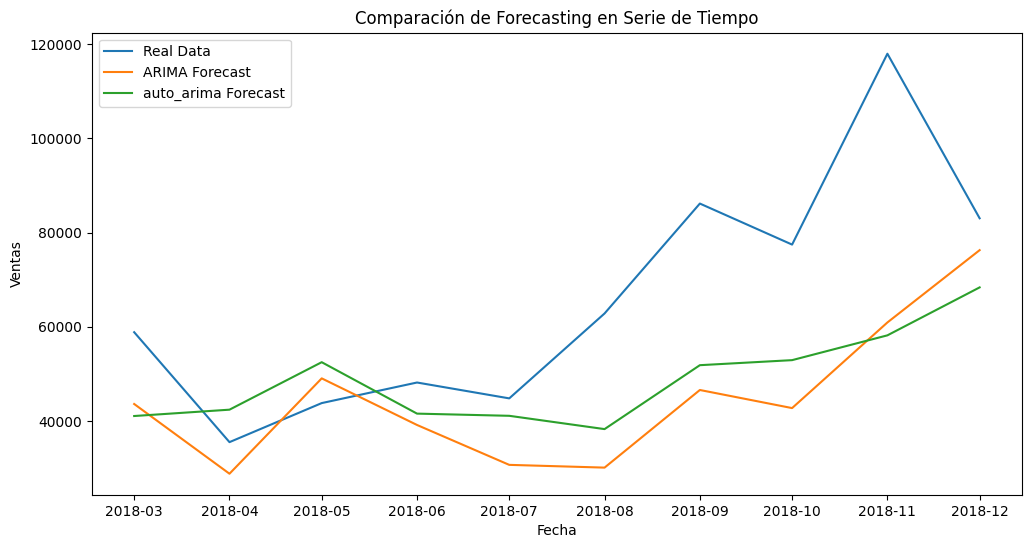

In [13]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Sales'], label='Real Data')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast')
plt.plot(test_data.index, forecast_auto_arima, label='auto_arima Forecast')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Comparación de Forecasting en Serie de Tiempo')
plt.legend()
plt.show()

In [14]:
# Evaluar el rendimiento de los modelos
def evaluate_model(predictions, test):
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    return rmse

rmse_arima = evaluate_model(forecast_arima, test_data['Sales'])
rmse_auto_arima = evaluate_model(forecast_auto_arima, test_data['Sales'])

print(f"RMSE ARIMA: {rmse_arima:.2f}")
print(f"RMSE AUTO ARIMA: {rmse_auto_arima:.2f}")

RMSE ARIMA: 27778.22
RMSE AUTO ARIMA: 25803.37
